In [1]:
!pip install netCDF4

In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from tensorflow.keras.layers import Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import zoom
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the .nc4 file
def load_nc4_files(file_paths, features, target):
    X_list = []
    y_list = []
    for file_path in file_paths:
        ds = nc.Dataset(file_path)
        # Extract features and target from each file
        feature_data = [ds.variables[feature][:] for feature in features]
        X = np.stack(feature_data, axis=-1)
        y = ds.variables[target][:]
        X_list.append(X)
        y_list.append(y)
    # Concatenate all samples from different files into one array
    X_all = np.concatenate(X_list, axis=0)
    y_all = np.concatenate(y_list, axis=0)
    return X_all, y_all
# Example usage:
file_paths = ['/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240628.0600.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240628.0900.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240628.1200.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240628.1500.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240628.1800.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240628.2100.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240629.0000.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240629.0300.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240629.0600.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240629.0900.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240629.1200.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240629.1500.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240629.1800.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240629.2100.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240630.0000.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240630.0300.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240630.0600.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240630.0900.021.nc4', '/content/drive/MyDrive/NASA_Data/GLDAS_NOAH025_3H.A20240630.1500.021.nc4']
features = ['Rainf_tavg', 'Evap_tavg', 'Albedo_inst', 'Wind_f_inst', 'Snowf_tavg',
            'Qle_tavg', 'Qh_tavg', 'SWdown_f_tavg', 'Tair_f_inst', 'LWdown_f_tavg', 'Rainf_f_tavg']
target = 'SoilMoi0_10cm_inst'
X, y = load_nc4_files(file_paths, features, target)

In [4]:
# Handle missing data
def handle_missing_data(X, strategy='mean'):
    imputer = SimpleImputer(strategy=strategy)
    num_samples, height, width, num_features = X.shape
    X_reshaped = X.reshape(num_samples * height * width, num_features)
    X_imputed = imputer.fit_transform(X_reshaped)
    X_imputed = X_imputed.reshape(num_samples, height, width, num_features)
    return X_imputed
X = handle_missing_data(X)

In [5]:
# Normalize X and y
scaler = MinMaxScaler()
num_samples, height, width, num_features = X.shape
X_reshaped = X.reshape(num_samples * height * width, num_features)
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(num_samples, height, width, num_features)

In [6]:
# Normalize y
y = np.nan_to_num(y, nan=np.nanmean(y))
y = y / np.max(y, axis=(1, 2), keepdims=True)

In [52]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_train.shape

(15, 600, 1440, 11)

## **Model**

In [54]:
mixed_precision.set_global_policy('mixed_float16')

In [55]:
def resize_data(X, target_shape):
    return np.array([zoom(x, (target_shape[0] / x.shape[0], target_shape[1] / x.shape[1], 1)) for x in X])

def resize_grid(y, target_shape):
    y_resized = []
    for y_sample in y:
        # Check if y_sample is scalar (1D), if so, expand to grid
        if len(y_sample.shape) == 1 or np.isscalar(y_sample):
            # Create a constant grid with scalar value
            grid = np.full(target_shape, y_sample)
            y_resized.append(grid)
        else:
            # If already a grid, just resize it
            resized_grid = zoom(y_sample, (target_shape[0] / y_sample.shape[0], target_shape[1] / y_sample.shape[1]))
            y_resized.append(resized_grid)
    return np.array(y_resized)


# Resize input data and target data to reduce memory consumption (e.g., 32x32)
target_shape = (64, 64)
X_train = resize_data(X_train, target_shape)
X_test = resize_data(X_test, target_shape)
# Resize target data (y_train and y_test)
y_train = resize_grid(y_train, target_shape)
y_test = resize_grid(y_test, target_shape)

In [56]:
# Custom accuracy-like metric for regression: percentage error tolerance
def custom_accuracy(y_true, y_pred):
    tolerance = 0.2
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    diff = K.abs(y_true - y_pred)
    return K.mean(K.less_equal(diff, tolerance))

In [57]:
# Step 1: Build the CNN Model
def build_cnn(input_shape):
    model = Sequential()
    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))  # Dropout layer to prevent overfitting
    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    # Third Convolutional Layer
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    # Flatten the output before feeding it into Dense layers
    model.add(Flatten())
    # Fully Connected Layer
    model.add(Dense(116, activation='relu'))
    model.add(Dropout(0.3))  # Dropout layer to prevent overfitting

    # Output Layer for Regression (1 neuron, no activation function for regression)
    #model.add(Dense(1), activation='linear')
    # Output Layer for Regression (reshaped to grid)
    model.add(Dense(target_shape[0] * target_shape[1], activation='linear'))  # Output a flattened grid
    model.add(Reshape(target_shape))  # Correctly pass the tuple (32, 32)
    return model

In [58]:
# Simplified CNN Model
def build_cnn(input_shape):
    model = Sequential()
    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    # Second Convolutional Layer (reduced filters)
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    # Flatten the output before feeding it into Dense layers
    model.add(Flatten())
    # Fully Connected Layer
    model.add(Dense(64, activation='relu'))
    # Output Layer for Regression (reshaped to grid)
    model.add(Dense(target_shape[0] * target_shape[1], activation='linear'))
    model.add(Reshape(target_shape))  # Reshape to match the target grid size
    return model

In [59]:
class RegressionMetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
    def on_epoch_end(self, epoch, logs=None):
        X_val, y_true = self.validation_data
        # Predict continuous values for validation data
        y_pred = self.model.predict(X_val)
        # Calculate regression metrics
        mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
        mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
        r2 = r2_score(y_true.flatten(), y_pred.flatten())
        print(f' - mse: {mse:.4f} - mae: {mae:.4f} - r2: {r2:.4f}')

In [60]:
# Step 2: Compile the Model
# Example of compiling the model for regression.
def compile_cnn(model, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', custom_accuracy])
    return model

In [61]:
# Step 3: Train the Model
def train_cnn(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    metrics_callback = RegressionMetricsCallback(validation_data=(X_val, y_val))
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[metrics_callback],
                        verbose=1)
    return history

In [62]:
# Step 4: Evaluate the Model
def evaluate_cnn(model, X_test, y_test):
    loss, mae, custom_accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"Test Loss: {loss}")
    print(f"Test MAE: {mae}")
    print(f"Test Custom Accuracy: {custom_accuracy}")
    return loss, mae

In [63]:
# Step 5: Visualize Training History
def plot_training_history(history):
    # Plot Training & Validation Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training & Validation MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('MAE Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Absolute Error')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [64]:
# Step 6: Main Training and Evaluation Workflow
def main():
    # Assuming X_train, X_test, y_train, y_test are preprocessed and ready
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])  # Height, Width, Num Features
    # Build and compile the model
    model = build_cnn(input_shape)
    model = compile_cnn(model, learning_rate=0.001)
    # Train the model
    history = train_cnn(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=4)
    # Evaluate the model on the test set
    evaluate_cnn(model, X_test, y_test)
    # Plot training history
    plot_training_history(history)
    model.save('my_model.h5')

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
 - mse: 7129.1719 - mae: 72.4305 - r2: -2.5571
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 533ms/step - custom_accuracy: 0.0618 - loss: 7162.7583 - mae: 72.4767 - val_custom_accuracy: 0.0233 - val_loss: 7129.1724 - val_mae: 72.4372
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
 - mse: 6546.3628 - mae: 69.9253 - r2: -2.2663
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - custom_accuracy: 0.0194 - loss: 7029.5098 - mae: 72.0905 - val_custom_accuracy: 0.0151 - val_loss: 6546.3623 - val_mae: 69.9317
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
 - mse: 4880.0366 - mae: 59.2321 - r2: -1.4349
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - custom_accuracy: 0.0140 - loss: 6296.2310 - mae: 68.4208 - val_custom_accuracy: 0.0095 - val_loss: 4880.0366 - val_mae: 59.2388
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
 - mse: 3009.8059 - mae: 40.0118 - r2: -0.5017
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - custom_accuracy: 0.0090 - loss: 4065.4275 - mae: 51.2942 - val_custom_accuracy: 0

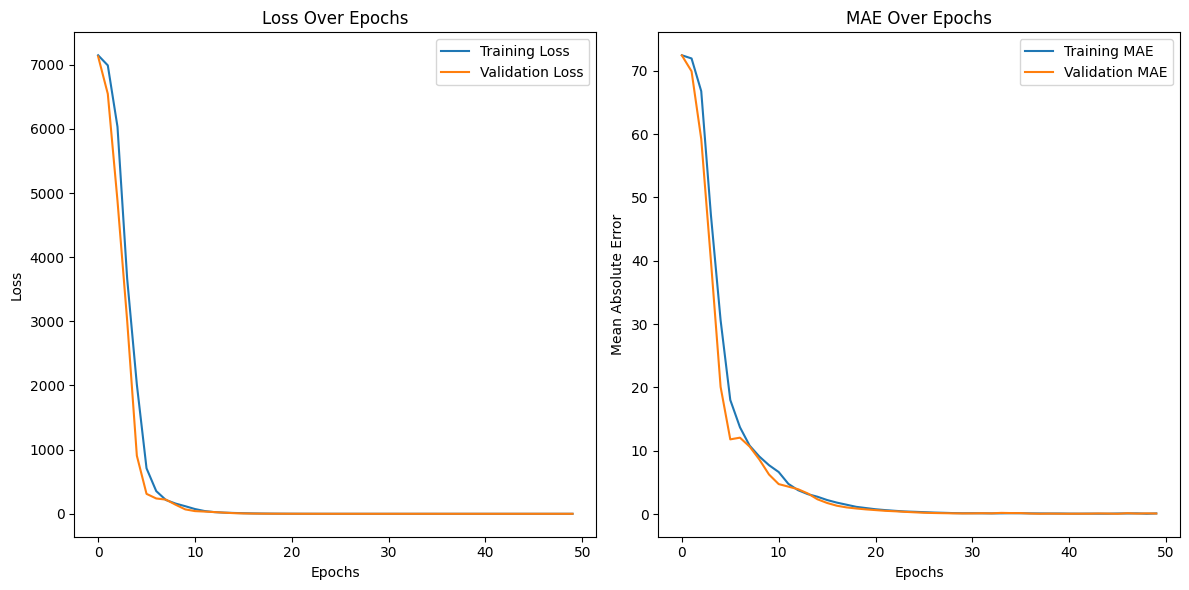

In [65]:
# Run the main function to execute the workflow
main()